In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import math
import sklearn as sk
from sklearn.linear_model import LogisticRegression as LR
import statsmodels.api as sm

%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

# Checkpoint 1: EDA (Research Question 2)

## Reading the cleaned transportation dataset

In [2]:
df = pd.read_csv('cleaned_transport_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Unnamed: 0,Date,Unemployment Rate - Seasonally Adjusted,State and Local Government Construction Spending - Transportation,State and Local Government Construction Spending - Infrastructure,Labor Force Participation Rate - Seasonally Adjusted,State and Local Government Construction Spending - Bridge,State and Local Government Construction Spending - Highway and Street,Real Gross Domestic Product - Seasonally Adjusted,Highway Fatalities,Is Recession,Recession Period,President,Political Party
0,0,2005-01-01,0.053,1.125000e+09,85000000.0,0.658,7.260000e+08,2.929000e+09,1.476785e+13,3305.0,not recession,pre-recession,Bush,Republican
1,1,2005-02-01,0.054,1.111000e+09,79000000.0,0.659,8.600000e+08,3.120000e+09,1.476785e+13,3042.0,not recession,pre-recession,Bush,Republican
2,2,2005-03-01,0.052,1.153000e+09,93000000.0,0.659,8.840000e+08,3.583000e+09,1.476785e+13,3334.0,not recession,pre-recession,Bush,Republican
3,3,2005-04-01,0.052,1.262000e+09,75000000.0,0.661,1.106000e+09,4.320000e+09,1.483971e+13,3686.0,not recession,pre-recession,Bush,Republican
4,4,2005-05-01,0.051,1.273000e+09,94000000.0,0.661,1.282000e+09,5.557000e+09,1.483971e+13,3874.0,not recession,pre-recession,Bush,Republican


The research question here is "What is the causal impact of highway and street spending on the seasonally adjusted real GDP?"

The quantitative variables of interest: `Real Gross Domestic Product - Seasonally Adjusted` and `State and Local Government Construction Spending - Highway and Street` overlay plot.

The categorical variables of interest: `Recession Period`, `Political Party` compared with `Real Gross Domestic Product - Seasonally Adjusted` and `State and Local Government Construction Spending - Highway and Street` bar graphs.

## Quantitative Variables Analysis

In [3]:
def standard_units(col):
    '''
    Calculated array of values in standard units.
    '''
    avg = np.mean(col)
    sd = np.std(col)
    return (col - avg) / sd

In [4]:
'''
Cleaning data, computing seasonally-adjusted highway spending 
to make comparison with seasonally-adjusted GDP easier.
'''

hway_spending = df[['Date', 'State and Local Government Construction Spending - Highway and Street']]
hway_spending = hway_spending.set_index('Date')
hway_spending_adjusted = sm.tsa.seasonal_decompose(hway_spending)

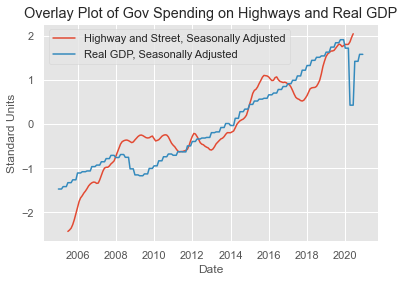

In [5]:
plt.plot(df['Date'], standard_units(hway_spending_adjusted.trend), label='Highway and Street, Seasonally Adjusted')
plt.plot(df['Date'], standard_units(df['Real Gross Domestic Product - Seasonally Adjusted']), label='Real GDP, Seasonally Adjusted')

plt.title('Overlay Plot of Gov Spending on Highways and Real GDP')
plt.xlabel('Date')
plt.ylabel('Standard Units')
plt.legend();

## Explanation of Graph

The graph shows that **there is a positive correlation between government spending on highways and streets and real GDP**, both of which are seasonally adjusted. However, the correlation isn't perfectly aligned, such as when highway and street spending dips but real GDP doesn't. This can be explained by confounding variables - although spending on highway and street may stagnante, other investments can drive economic growth in its place (eg. technological advancements). Additionally, the government may respond to declining GDP by increasing government spending to stimulate the economy (indicating a negative correlation), which explains why highway and street spending doesn't fall with GDP in 2008 and 2020.

Regardless, we still believe the graph in general supports the claim that there is a positive correlation between government spending on highways and real GDP. According to Keynesian economic theory, increased government spending on infrastructure like highways and streets should *increase* an economy's GDP - we expect there to be a positive causal effect. We will use this fact to motivate our search for the causal effect of this spending on real GDP.

## Categorical Variables Analysis

In [6]:
'''
Calculating the change in real GDP
'''
df['Real GDP Change'] = df['Real Gross Domestic Product - Seasonally Adjusted'].pct_change()

In [7]:
df_recession = df[(df['Is Recession'] == 'recession')]
df_not_recession = df[(df['Is Recession'] != 'recession')]

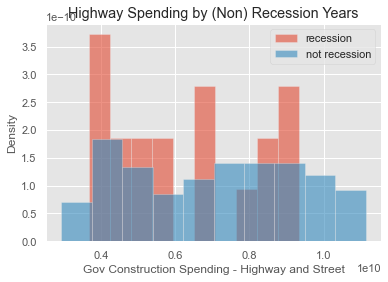

In [8]:
plt.hist(df_recession['State and Local Government Construction Spending - Highway and Street'], density=True, 
         alpha=0.6, label='recession')

plt.hist(df_not_recession['State and Local Government Construction Spending - Highway and Street'], density=True, 
         alpha=0.6, label='not recession')
plt.title('Highway Spending by (Non) Recession Years')
plt.xlabel('Gov Construction Spending - Highway and Street')
plt.ylabel('Density')
plt.legend();

In [9]:
df_recession = df[(df['Is Recession'] == 'recession') & (df['Real GDP Change'] != 0)]
df_not_recession = df[(df['Is Recession'] != 'recession') & (df['Real GDP Change'] != 0)]

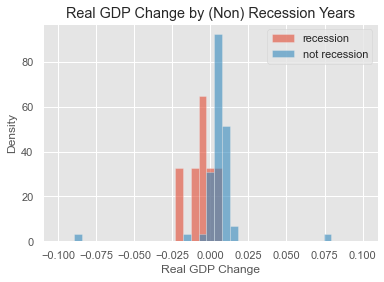

In [10]:
plt.hist(df_recession['Real GDP Change'], density=True, 
         alpha=0.6, label='recession', bins=np.linspace(-0.1, 0.1, 40))

plt.hist(df_not_recession['Real GDP Change'], density=True, 
         alpha=0.6, label='not recession', bins=np.linspace(-0.1, 0.1, 40))
plt.title('Real GDP Change by (Non) Recession Years')
plt.xlabel('Real GDP Change')
plt.ylabel('Density')
plt.legend();

In [11]:
df_democrat = df[(df['Political Party'] == 'Democrat')]
df_republican = df[(df['Political Party'] == 'Republican')]

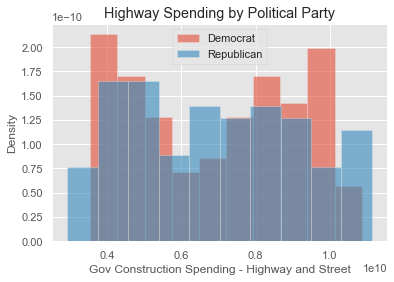

In [12]:
plt.hist(df_democrat['State and Local Government Construction Spending - Highway and Street'], density=True, 
         alpha=0.6, label='Democrat')

plt.hist(df_republican['State and Local Government Construction Spending - Highway and Street'], density=True, 
         alpha=0.6, label='Republican')
plt.title('Highway Spending by Political Party')
plt.xlabel('Gov Construction Spending - Highway and Street')
plt.ylabel('Density')
plt.legend();

In [13]:
df_democrat = df[(df['Political Party'] == 'Democrat') & (df['Real GDP Change'] != 0)]
df_republican = df[(df['Political Party'] == 'Republican') & (df['Real GDP Change'] != 0)]

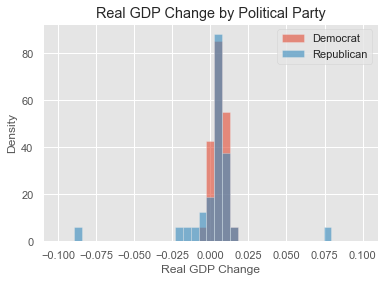

In [14]:
plt.hist(df_democrat['Real GDP Change'], density=True, 
         alpha=0.6, label='Democrat', bins=np.linspace(-0.1, 0.1, 40))

plt.hist(df_republican['Real GDP Change'], density=True, 
         alpha=0.6, label='Republican', bins=np.linspace(-0.1, 0.1, 40))
plt.title('Real GDP Change by Political Party')
plt.xlabel('Real GDP Change')
plt.ylabel('Density')
plt.legend();

## Explanation of Graphs

Graph 1: When there is no recession, the US generally spends more on highways and streets.

Graph 2: The distribution in the change in real GDP is different between recession vs. no recession. Recession years generally see negative real GDP changes, whereas non-recession years are generally positive.

The first two graphs demonstrate that the **recession period may be a confounding variable** since it affects the treatment and outcome variables.

Graph 3: Highway and street spending during Democrat and Republican presidencies does not seem to differ very much. This spending during Republican presidents seem to be slightly more extreme, with either more or less highway spending than during Democratic presidencies.

Graph 4: There does not seem to be a very strong difference in distributions of real GDP changes between Democrat and Republican presidencies.

Graphs 3 and 4 were created to see if highway and street spending would be confounded by the party which holds the presidency - the intuition being that one party may favor investments in infrastructure more than others. However, the correlation from these graphs appear very weak.